In [1]:
import pandas as pd
import numpy  as np 

import matplotlib.pyplot as plt
import statistics as stat

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Setting seed

SEED = 101
np.random.seed(SEED)

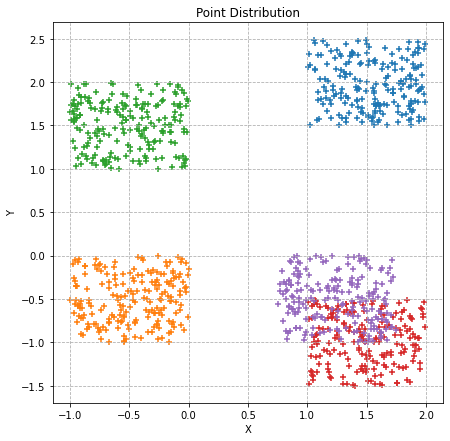

In [4]:
# Toy Dataset creation

## Creating a toy dataset

rand_values = np.random.rand(1000)

cluster_1 = np.array(list(zip( 1  + np.random.rand(200), 1.5 + np.random.rand(200))))
cluster_2 = np.array(list(zip( -1 + np.random.rand(200),  -1 + np.random.rand(200))))
cluster_3 = np.array(list(zip( -1 + np.random.rand(200),   1 + np.random.rand(200))))
cluster_4 = np.array(list(zip(  1 + np.random.rand(200),-1.5 + np.random.rand(200))))
cluster_5 = np.array(list(zip(.75 + np.random.rand(200),  -1 + np.random.rand(200))))

clusters = [cluster_1, cluster_2, cluster_3, cluster_4, cluster_5]

## Plotting the toy dataset

fig = plt.figure(figsize=(7, 7))
for cluster in clusters:
    plt.scatter(cluster[:,0], cluster[:,1], marker='+')
plt.grid(ls='--')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Point Distribution');

## Creating the toy dataframe

toy_df = pd.DataFrame()
for cluster_id, cluster in enumerate(clusters):
    sub_df = pd.DataFrame(cluster, columns=['x', 'y'])
    sub_df['cluster_id'] = cluster_id + 1
    toy_df = pd.concat([toy_df, sub_df])

In [5]:
# Neural Network 

## Initializing the weights
def nn_init(layer_size):
    input_layer = layer_size[0]
    hidden_1 = layer_size[1]
    hidden_2 = layer_size[2]
    output_layer = layer_size[3]
        
    nnet = {
        "w0": np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
        "w1": np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
        "w2": np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
    }
       
    return nnet

## Setting the activation functions
def relu(x, derivative=False):
    if derivative:
        x[x <= 0] = 0
        x[x >  0] = 1
        return x
    else:
        x[x <= 0] = 0
        return x
    
def sigmoid(x, derivative=False):
    if derivative:
        return np.exp(-x) / ((np.exp(-x) + 1) ** 2)
    else:
        return 1/(1 + np.exp(-x))

def softmax(x, derivative=False):
    exp_shifted = np.exp(x - x.max())
    if derivative:
        return exp_shifted / np.sum(exp_shifted, axis = 0) * ((1 - exp_shifted) / np.sum(exp_shifted, axis = 0))
    else:
        return exp_shifted / np.sum(exp_shifted, axis=0)

## Constructing the forward pass
def nn_forward(x, model):
    nn_state = {}
    nn_state['o0'] = x
    
    nn_state['z1'] = np.dot(model['w0'], nn_state['o0'])
    nn_state['o1'] = sigmoid(nn_state['z1'])
    
    nn_state['z2'] = np.dot(model['w1'], nn_state['o1'])
    nn_state['o2'] = sigmoid(nn_state['z2'])
    
    nn_state['z3'] = np.dot(model['w2'], nn_state['o2'])
    nn_state['o3'] = softmax(nn_state['z3'])
    
    return nn_state

## Constructing the cost-function
def cross_entropy(o, y):
    c = np.dot(y, np.log(o)) + np.dot((1 - y), np.log(1 - o))
    return -c

## Constructing the backward pass
def nn_backward(x, y, model):
    nn_state = nn_forward(x, model)
    
    nn_state['d3'] = nn_state['o3'] - y
    nn_state['d2'] = np.dot(nn_state['d3'], model['w2']) * softmax(nn_state['z2'], derivative=True)
    nn_state['d1'] = np.dot(nn_state['d2'], model['w1']) * sigmoid(nn_state['z1'], derivative=True)
    
    nn_state['D2'] = np.outer(nn_state['d3'], nn_state['o2'])
    nn_state['D1'] = np.outer(nn_state['d2'], nn_state['o1'])
    nn_state['D0'] = np.outer(nn_state['d1'], nn_state['o0'])
    
    return nn_state

## Training the neural network
def nn_train(epochs, layer_size, X_train, y_train, lr=1):
    
    best_model = None
    best_cost = 1e10
    best_accuracy = 0
    
    for e in range(epochs):
        samples = X_train.shape[0]
        cost = 0
        hit_count = 0
        
        nn_model = nn_init(layer_size)
    
        for i in range(samples):
            model_state = nn_backward(X_train[i], y_train[i], nn_model)
            cost += cross_entropy(model_state['o3'], y_train[i])
            
            nn_model['w0'] -= lr * model_state['D0']
            nn_model['w1'] -= lr * model_state['D1']
            nn_model['w2'] -= lr * model_state['D2']
            
            if np.argmax(model_state['o3']) == np.argmax(y_train[i]):
                hit_count += 1
        
        cost = cost / samples
        accuracy = hit_count / samples
        
        if (cost < best_cost) and (accuracy > best_accuracy):
            best_cost = cost
            best_accuracy = accuracy
            best_model = nn_model
        
    print(f"Training\n-----\nBest cost: {best_cost:.3f}, Best accuracy: {best_accuracy:.3f}\n")      
    return best_model
        
def nn_predict(nn_model, classes, X_test):
    predictions = []
    for i in range(X_test.shape[0]):
        model_state = nn_forward(X_test[i], nn_model)
        predictions.append(classes[np.argmax(model_state['o3'])])
    return predictions

In [6]:
# Coding the confusion matrix function

import seaborn as sns

def plot_confusion_matrix(y_train, y_test, y_predicted):
    labels = list(np.unique(y_train))
    cm = confusion_matrix(y_test, y_predicted, labels=labels)
    ax = sns.heatmap(cm, annot=True, annot_kws={"size": 16})
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels, rotation=0)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

In [7]:
## Preprocessing toy dataset

X = toy_df[['x', 'y']]
y = toy_df[['cluster_id']]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

sc = StandardScaler()
ohe = OneHotEncoder()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
y_train_ohe = ohe.fit_transform(y_train).toarray()

In [8]:
%%time

epochs = 100
layer_size = [X_train.shape[1], 10, 10, len(ohe.categories_[0])]
nn_model = nn_train(epochs, layer_size, X_train_sc, y_train_ohe, lr=1)
m_nn_y_predicted = nn_predict(nn_model, ohe.categories_[0], X_test_sc)

m_nn_score = accuracy_score(y_test, m_nn_y_predicted)
print(f"Our Neural Network Test Set Accuracy Score: {m_nn_score:.3f}")
print(f"Training Data Count: {len(X_train)}, %Training Data: {100 * len(X_train)/len(X):.2f}")
print(f"Test Data Count: {len(X_test)}, %Test Data: {100 * len(X_test)/len(X):.2f}")

Training
-----
Best cost: 1.325, Best accuracy: 0.677

Our Neural Network Test Set Accuracy Score: 0.823
Training Data Count: 700, %Training Data: 70.00
Test Data Count: 300, %Test Data: 30.00
CPU times: user 5.66 s, sys: 7.02 ms, total: 5.67 s
Wall time: 5.67 s


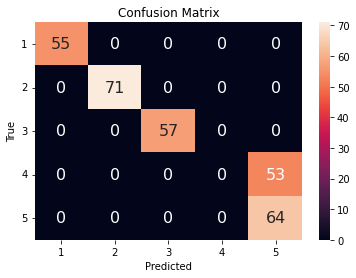

In [9]:
plot_confusion_matrix(y_train, y_test, m_nn_y_predicted)

Text(0.5, 0, 'X')

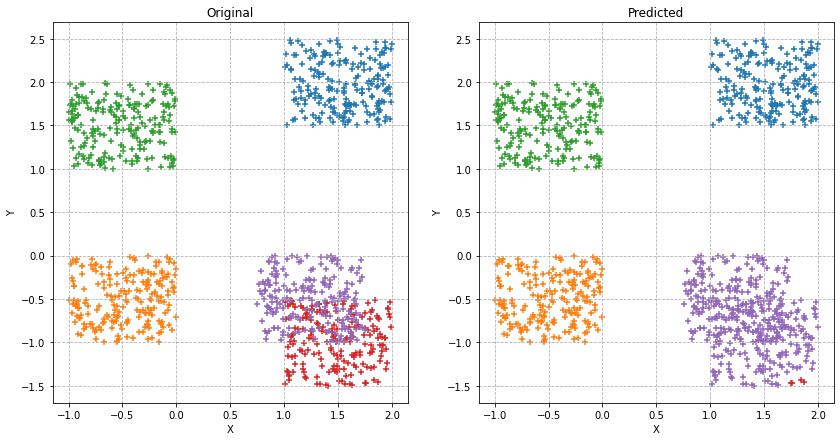

In [10]:
# Plotting Original vs Predicted for nn

m_nn_y_train_predicted = nn_predict(nn_model, ohe.categories_[0], X_train_sc)

train_df = X_train
train_df['cluster_id'] = m_nn_y_train_predicted

test_df = X_test
test_df['cluster_id']  = m_nn_y_predicted

main_df = pd.concat([X_train, X_test])

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for _, data in toy_df.groupby('cluster_id'):
    axs[0].scatter(data['x'], data['y'], marker='+')
axs[0].set_title("Original")
axs[0].grid(ls='--')
axs[0].set_ylabel('Y')
axs[0].set_xlabel('X')

for _, data in main_df.groupby('cluster_id'):
    axs[1].scatter(data['x'], data['y'], marker='+')
axs[1].set_title("Predicted")
axs[1].grid(ls='--')
axs[1].set_ylabel('Y')
axs[1].set_xlabel('X')

In [11]:
# Loading Iris dataset

In [12]:
from sklearn.datasets import load_iris

irisData = load_iris()
 
X = irisData.data
y = irisData.target.reshape(-1,1)
 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=SEED)

sc = StandardScaler()
ohe = OneHotEncoder()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
y_train_ohe = ohe.fit_transform(y_train).toarray()

In [13]:
%%time

epochs = 100
layer_size = [X_train.shape[1], 5, 5, len(ohe.categories_[0])]
nn_model = nn_train(epochs, layer_size, X_train_sc, y_train_ohe, lr=1)
m_nn_y_predicted = nn_predict(nn_model, ohe.categories_[0], X_test_sc)

m_nn_score = accuracy_score(y_test, m_nn_y_predicted)
print(f"Our Neural Network Test Set Accuracy Score: {m_nn_score:.3f}")
print(f"Training Data Count: {len(X_train)}, %Training Data: {100 * len(X_train)/len(X):.2f}")
print(f"Test Data Count: {len(X_test)}, %Test Data: {100 * len(X_test)/len(X):.2f}")

Training
-----
Best cost: 1.419, Best accuracy: 0.607

Our Neural Network Test Set Accuracy Score: 0.711
Training Data Count: 112, %Training Data: 74.67
Test Data Count: 38, %Test Data: 25.33
CPU times: user 912 ms, sys: 611 µs, total: 913 ms
Wall time: 910 ms


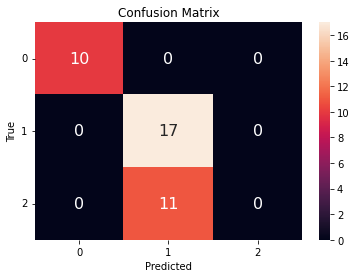

In [14]:
plot_confusion_matrix(y_train, y_test, m_nn_y_predicted)

In [16]:
# Loading Car Dataset

In [17]:
carData = pd.read_csv('./car.data', encoding='utf-8', header=None)

carData.columns = ['buying', 'maintainence', 'doors', 'persons', 'lug_boot', 'safety', 'class']
carData = carData.replace({"class": {"unacc": 4, "acc": 3,'good': 2,'vgood':1}})

X = pd.get_dummies(carData.drop('class', axis=1))
y = carData[['class']]
 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=SEED)

sc = StandardScaler()
ohe = OneHotEncoder()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
y_train_ohe = ohe.fit_transform(y_train).toarray()

In [18]:
%%time

epochs = 100
layer_size = [X_train.shape[1], 5, 5, len(ohe.categories_[0])]
nn_model = nn_train(epochs, layer_size, X_train_sc, y_train_ohe, lr=1)
m_nn_y_predicted = nn_predict(nn_model, ohe.categories_[0], X_test_sc)

m_nn_score = accuracy_score(y_test, m_nn_y_predicted)
print(f"Our Neural Network Test Set Accuracy Score: {m_nn_score:.3f}")
print(f"Training Data Count: {len(X_train)}, %Training Data: {100 * len(X_train)/len(X):.2f}")
print(f"Test Data Count: {len(X_test)}, %Test Data: {100 * len(X_test)/len(X):.2f}")

Training
-----
Best cost: 0.868, Best accuracy: 0.814

Our Neural Network Test Set Accuracy Score: 0.817
Training Data Count: 1296, %Training Data: 75.00
Test Data Count: 432, %Test Data: 25.00
CPU times: user 10.7 s, sys: 3.71 ms, total: 10.7 s
Wall time: 10.7 s


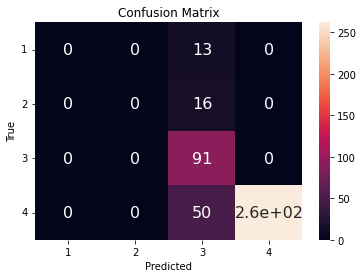

In [19]:
plot_confusion_matrix(y_train, y_test, m_nn_y_predicted)